In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# LSTM Multivariate
Using lookback = 1

## Load and prepare the data

In [2]:
df = pd.read_csv('../cleaned_data/EXCL.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,7 DAYS STD DEV,14 DAYS MA,21 DAYS MA,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,
2012-10-17,3.059533,1.053684,3.007273,2.938809,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,3.395286
2012-10-18,3.111350,1.915311,3.046031,2.964583,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,3.395286
2012-10-19,3.176120,1.970523,3.081559,2.988210,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,3.486288
2012-10-22,3.253845,1.767559,3.120318,3.016132,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,3.304284
2012-10-23,3.299184,0.647818,3.149386,3.035463,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,3.213282


### Split the dataset into train and test

In [3]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [4]:
train_y = train_dataset[['Close']]

### Create the train dataset

In [5]:
hops = 1
train_len = len(train_dataset)

X_train = []
y_train = []

for i in range(hops, train_len):
    X_train.append(train_dataset[i-hops:i])
    y_train.append(train_y.iloc[i][0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
X_train.shape

(1966, 1, 12)

In [7]:
y_train.shape

(1966,)

**Reshape the X_train into 3d**
Required for LSTM

In [8]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_train_reshaped.shape

(1966, 1, 12)

### Create the test dataset

In [9]:
train_dataset_last_hops = train_dataset.iloc[-1*hops:]
test_dataset_full = test_dataset.copy()
test_dataset_full = pd.concat((train_dataset_last_hops, test_dataset_full), axis=0)

In [10]:
test_dataset_full_y = test_dataset_full[['Close']]

In [11]:
test_len = test_dataset_full.shape[0]

X_test = []
y_test = []

for i in range(hops, test_len):
    X_test.append(test_dataset_full[i-hops:i])
    y_test.append(test_dataset_full_y.iloc[i][0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
X_test.shape

(492, 1, 12)

## Modeling with LSTM

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [14]:
def build_model(lstm_unit1, lstm_unit2, hops):
    """
    Function to build LSTM model architecture
    """
    model = Sequential()
    model.add(LSTM(units=lstm_unit1, return_sequences=True, input_shape=(hops,12)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=lstm_unit2))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(model.summary())
    return model

In [15]:
def fit_model(model, X_train, y_train, epochs, batch_size):
    """
    Function to fit the model with specified epochs and batch size
    """
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return history

In [16]:
def predict(model, X_test):
    predictions = model.predict(X_test)
    actual_close = df[['Close']]
    actual_close = pd.DataFrame(actual_close.iloc[train_len:, 0])
    predictions = pd.DataFrame(predictions)
    predictions.reset_index(drop=True, inplace=True)
    predictions.index = test_dataset.index
    predictions['Actual'] = actual_close['Close']
    predictions.rename(columns={0:'Pred'}, inplace=True)
    return predictions

In [17]:
def plot_pred_act(predictions_df):
    """
    Function to plot and compare y_true and y_pred
    """
    plt.title('True vs Predicted')
    predictions_df['Actual'].plot(figsize=(20,8), legend=True, color='blue')
    predictions_df['Pred'].plot(legend=True, color='red', figsize=(20,8))
    plt.legend(loc='best')
    plt.xlabel('Standardized Close Price')
    plt.show()

In [18]:
from joblib import load

close_scaler = load('../feature_engineering/excl_close_scaler.bin')

In [19]:
def inverse_pred_act(predictions_df):
    """
    Function to inverse standardized Close value
    """
    inversed_pred = close_scaler.inverse_transform(np.array(predictions_df['Pred']).reshape(-1,1))
    inversed_act = close_scaler.inverse_transform(np.array(predictions_df['Actual']).reshape(-1,1))
    inversed = pd.DataFrame(inversed_pred)
    inversed['Actual'] = inversed_act
    inversed.rename({0:'Pred'}, axis=1, inplace=True)
    inversed.index = test_dataset.index
    return inversed

In [20]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    # plt.hist(error, bins=25)
    sns.displot(error)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

In [21]:
"""
Evaluation metrics
"""
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [22]:
def evaluate(inversed_df):
    """
    Function to evaluate predictions
    """
    rmse_ = rmse(inversed_df['Actual'], inversed_df['Pred'])
    mape_ = mape(inversed_df['Actual'], inversed_df['Pred'])
    r2 = r2_score(inversed_df['Actual'], inversed_df['Pred'])
    return rmse_, mape_, r2

In [23]:
epochs_candidates = [100,150,200]
batch_size_candidates = [16,32,64]
lstm_unit1_candidates = [50, 100]
lstm_unit2_candidates = [50, 100]

In [24]:
models = {}
predictions_dfs = {}
inversed_dfs = {}
performances = {}

In [25]:
modelID = 1
for e in epochs_candidates:
    for b in batch_size_candidates:
        for l1 in lstm_unit1_candidates:
            for l2 in lstm_unit2_candidates:
                model = build_model(lstm_unit1=l1, lstm_unit2=l2, hops=1)
                history = fit_model(model, X_train, y_train, epochs=e, batch_size=b)
                models[f'Model-{modelID}'] = (model, history)
                
                predictions = predict(model, X_test)
                predictions_dfs[f'Model-{modelID}'] = predictions
                
                inversed = inverse_pred_act(predictions)
                inversed_dfs[f'Model-{modelID}'] = inversed
                rmse_, mape_, r2 = evaluate(inversed)
                
                performances[f'Model-{modelID}'] = {
                    'epochs': e,
                    'batch size': b,
                    'lstm unit 1': l1,
                    'lstm unit 2': l2,
                    'RMSE': rmse_,
                    'MAPE': mape_,
                    'r2': r2
                }
                modelID += 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             12600     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 32,851
Trainable params: 32,851
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
123/123 [==========================

123/123 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 87/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 88/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0193
Epoch 89/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 90/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 91/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 92/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 93/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 94/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 95/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 96/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 97/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 98/100
123/

123/123 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 72/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 73/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 74/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 75/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 76/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 77/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 78/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 79/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 80/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 81/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 82/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 83/100
123/

123/123 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 57/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 58/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 59/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 60/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 61/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 62/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 63/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 64/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 65/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 66/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 67/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 68/100
123/

123/123 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 42/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 43/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 44/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 45/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 46/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 47/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 48/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 49/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 50/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 51/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 52/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 53/100
123/

62/62 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 27/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 28/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 29/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 30/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 31/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 32/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 33/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 34/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 35/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 36/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 37/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 38/100
62/62 [=====================

62/62 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 14/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 15/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 16/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 17/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 18/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 19/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 20/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 21/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 22/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 23/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 24/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 25/100
62/62 [=====================

None
Epoch 1/100
62/62 [==============================] - 2s 2ms/step - loss: 0.4661
Epoch 2/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0498
Epoch 3/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0412
Epoch 4/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 5/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 6/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 7/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 8/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 9/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 10/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 11/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 12/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 13/100
62/62 [============

 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 100)            45200     
                                                                 
 dropout_14 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 125,701
Trainable params: 125,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
62/62 [==============================] - 2s 2ms/step - loss: 0.3680
Epoch 2/100
62/62 [==============================] 

62/62 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 90/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 91/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 92/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 93/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 94/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 95/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 96/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 97/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 98/100
62/62 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 99/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 100/100
16/16 [==============================] - 0s 1ms/step
Model: "sequential_8"
_________________________________

31/31 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 77/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 78/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 79/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 80/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 81/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 82/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 83/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 84/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 85/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 86/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 87/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 88/100
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 64/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 65/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 66/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 67/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 68/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 69/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 70/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 71/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 72/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 73/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 74/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 75/100
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 51/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 52/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 53/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 54/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 55/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 56/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 57/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 58/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 59/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 60/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 61/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 62/100
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 38/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 39/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 40/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 41/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 42/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 43/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 44/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 45/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 46/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 47/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 48/100
31/31 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 49/100
31/31 [=====================

123/123 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 24/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 25/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 26/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 27/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 28/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 29/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 30/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 31/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 32/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 33/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 34/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 35/150
123/

123/123 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 122/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 123/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 124/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 125/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 126/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 127/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 128/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 129/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 130/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 131/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 132/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 

123/123 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 56/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 57/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 58/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 59/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 60/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 61/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 62/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 63/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 64/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 65/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 66/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 67/150
123/

 lstm_28 (LSTM)              (None, 1, 100)            45200     
                                                                 
 dropout_28 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_29 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_29 (Dropout)        (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 75,451
Trainable params: 75,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
123/123 [==============================] - 2s 2ms/step - loss: 0.2344
Epoch 2/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0396
Epoch 3/150
123/123 [==============

123/123 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 89/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 90/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 91/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 92/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 93/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 94/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 95/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 96/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 97/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 98/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 99/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 100/150
123

123/123 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 23/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 24/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 25/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 26/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 27/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 28/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 29/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 30/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 31/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 32/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 33/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 34/150
123/

123/123 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 121/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 122/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 123/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 124/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 125/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 126/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 127/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 128/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 129/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 130/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 131/150
123/123 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 

62/62 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 57/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 58/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 59/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 60/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 61/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 62/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 63/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 64/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 65/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 66/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 67/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 68/150
62/62 [=====================

                                                                 
 lstm_35 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_35 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 73,101
Trainable params: 73,101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
62/62 [==============================] - 2s 2ms/step - loss: 0.4873
Epoch 2/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0492
Epoch 3/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0394
Epoch 4/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 5/150
62/62 [==============================] - 0s 2ms/step - loss: 0.03

Epoch 94/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 95/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 96/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 97/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 98/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 99/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 100/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 101/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 102/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 103/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 104/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 105/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 106/150
62/62 [=

62/62 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 31/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 32/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 33/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 34/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 35/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 36/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 37/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 38/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 39/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 40/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 41/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 42/150
62/62 [=====================

62/62 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 131/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 132/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 133/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 134/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 135/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 136/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 137/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 138/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 139/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 140/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 141/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 142/150
62/62 [=========

62/62 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 68/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 69/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 70/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 71/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 72/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 73/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 74/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 75/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 76/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 77/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 78/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 79/150
62/62 [=====================

31/31 [==============================] - 0s 2ms/step - loss: 0.0747
Epoch 4/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0548
Epoch 5/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0477
Epoch 6/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0450
Epoch 7/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 8/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 9/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0347
Epoch 10/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0342
Epoch 11/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 12/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0325
Epoch 13/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 14/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0295
Epoch 15/150
31/31 [===========================

31/31 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 105/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 106/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 107/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 108/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 109/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 110/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 111/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 112/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 113/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 114/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 115/150
31/31 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 116/150
31/31 [=========

31/31 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 41/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 42/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 43/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 44/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 45/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 46/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 47/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 48/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 49/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 50/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 51/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 52/150
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 141/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 142/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 143/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 144/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 145/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 146/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 147/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 148/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 149/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 150/150
16/16 [==============================] - 0s 1ms/step
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Sh

31/31 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 78/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 79/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 80/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 81/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 82/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 83/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 84/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 85/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 86/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 87/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 88/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 89/150
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 14/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 15/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 16/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 17/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 18/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 19/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 20/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 21/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 22/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 23/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 24/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 25/150
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 115/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 116/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 117/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 118/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 119/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 120/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 121/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 122/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 123/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 124/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 125/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 126/150
31/31 [=========

123/123 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 50/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 51/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 52/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 53/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 54/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 55/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 56/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 57/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 58/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 59/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 60/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 61/200
123/

123/123 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 148/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 149/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 150/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 151/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 152/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 153/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 154/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 155/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 156/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 157/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 158/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 

123/123 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 32/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 33/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 34/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 35/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 36/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 37/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 38/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 39/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 40/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 41/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 42/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 43/200
123/

123/123 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 130/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 131/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 132/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 133/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 134/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 135/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 136/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 137/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 138/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 139/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 140/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 

123/123 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 14/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 15/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 16/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 17/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 18/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 19/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 20/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 21/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 22/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 23/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 24/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 25/200
123/

123/123 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 112/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 113/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 114/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 115/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 116/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 117/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 118/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 119/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 120/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 121/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 122/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 

 dropout_55 (Dropout)        (None, 100)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 101       
                                                                 
Total params: 125,701
Trainable params: 125,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
123/123 [==============================] - 2s 2ms/step - loss: 0.2247
Epoch 2/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 3/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 4/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 5/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 6/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 7/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 8/200
123/123

123/123 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 95/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 96/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 97/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 98/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 99/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 100/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 101/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 102/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 103/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 104/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 105/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 106/2

123/123 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 192/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 193/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 194/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 195/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 196/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 197/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 198/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 199/200
123/123 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 200/200
16/16 [==============================] - 0s 1ms/step
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 

Epoch 78/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 79/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 80/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 81/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 82/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 83/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 84/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 85/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 86/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 87/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 88/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 89/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 90/200
62/62 [========

62/62 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 179/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 180/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 181/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 182/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 183/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 184/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 185/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 186/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 187/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 188/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 189/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 190/200
62/62 [=========

62/62 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 66/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 67/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 68/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 69/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 70/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 71/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 72/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 73/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 74/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 75/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 76/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 77/200
62/62 [=====================

62/62 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 166/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 167/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 168/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 169/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 170/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 171/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 172/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 173/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 174/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 175/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 176/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 177/200
62/62 [=========

62/62 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 52/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 53/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 54/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 55/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 56/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 57/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 58/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 59/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 60/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 61/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 62/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 63/200
62/62 [=====================

62/62 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 152/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 153/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 154/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 155/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 156/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 157/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 158/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 159/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 160/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 161/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 162/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 163/200
62/62 [=========

62/62 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 38/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 39/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 40/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 41/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 42/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 43/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 44/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 45/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 46/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 47/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 48/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 49/200
62/62 [=====================

62/62 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 138/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 139/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 140/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 141/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 142/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 143/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 144/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 145/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 146/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 147/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 148/200
62/62 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 149/200
62/62 [=========

31/31 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 24/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 25/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 26/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 27/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 28/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 29/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 30/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 31/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 32/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0213
Epoch 33/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 34/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 35/200
31/31 [=====================

31/31 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 125/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 126/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 127/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 128/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 129/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 130/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 131/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 132/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 133/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 134/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 135/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 136/200
31/31 [=========

31/31 [==============================] - 0s 3ms/step - loss: 0.0319
Epoch 11/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0299
Epoch 12/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0320
Epoch 13/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0262
Epoch 14/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 15/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 16/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 17/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 18/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0233
Epoch 19/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 20/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0224
Epoch 21/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 22/200
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 112/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 113/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 114/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 115/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 116/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 117/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 118/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 119/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 120/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 121/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 122/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 123/200
31/31 [=========

                                                                 
Total params: 75,451
Trainable params: 75,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
31/31 [==============================] - 2s 3ms/step - loss: 0.7106
Epoch 2/200
31/31 [==============================] - 0s 3ms/step - loss: 0.1368
Epoch 3/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0531
Epoch 4/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0444
Epoch 5/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0416
Epoch 6/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0383
Epoch 7/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0382
Epoch 8/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0330
Epoch 9/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0309
Epoch 10/200
31/31 [==============================] - 0s 3ms/step - loss:

31/31 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 99/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 100/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 101/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 102/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 103/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 104/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 105/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 106/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 107/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 108/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 109/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 110/200
31/31 [==========

31/31 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 199/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 200/200
16/16 [==============================] - 0s 1ms/step
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 1, 100)            45200     
                                                                 
 dropout_70 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_71 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_71 (Dropout)        (None, 100)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 101       
                                  

31/31 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 86/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 87/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 88/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 89/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 90/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 91/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 92/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 93/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 94/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 95/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 96/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 97/200
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 186/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 187/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 188/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 189/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 190/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 191/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 192/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 193/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 194/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 195/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 196/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 197/200
31/31 [=========

In [26]:
perf_df = pd.DataFrame(performances)
perf_df = perf_df.transpose()

In [27]:
perf_df.sort_values('MAPE')

,epochs,batch size,lstm unit 1,lstm unit 2,RMSE,MAPE,r2
Model-12,100.0,64.0,100.0,100.0,66.696175,1.879881,0.963104
Model-24,150.0,64.0,100.0,100.0,65.998441,1.908525,0.963872
Model-23,150.0,64.0,100.0,50.0,66.635529,1.910956,0.963171
Model-35,200.0,64.0,100.0,50.0,66.794554,1.917604,0.962995
Model-15,150.0,16.0,100.0,50.0,67.693047,1.965083,0.961993
Model-22,150.0,64.0,50.0,100.0,67.120749,1.968203,0.962633
Model-9,100.0,64.0,50.0,50.0,67.372339,1.976329,0.962352
Model-20,150.0,32.0,100.0,100.0,69.113391,2.054710,0.960381
Model-1,100.0,16.0,50.0,50.0,70.545675,2.077835,0.958722
Model-27,200.0,16.0,100.0,50.0,69.881631,2.087152,0.959496


**Best model**

In [30]:
perf_df.sort_values('MAPE').iloc[0:2]

,epochs,batch size,lstm unit 1,lstm unit 2,RMSE,MAPE,r2
Model-12,100.0,64.0,100.0,100.0,66.696175,1.879881,0.963104
Model-24,150.0,64.0,100.0,100.0,65.998441,1.908525,0.963872


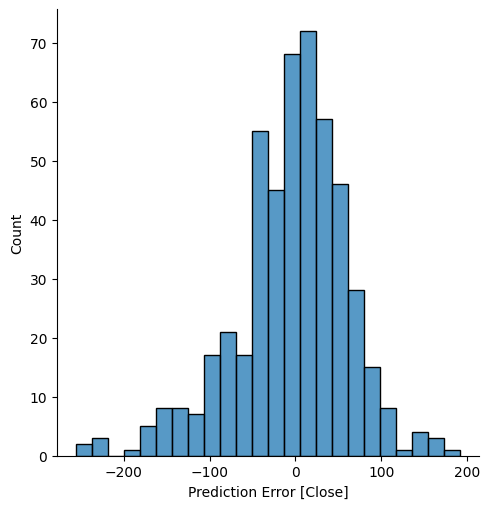

In [31]:
plotErrorHist(inversed_dfs['Model-24'])

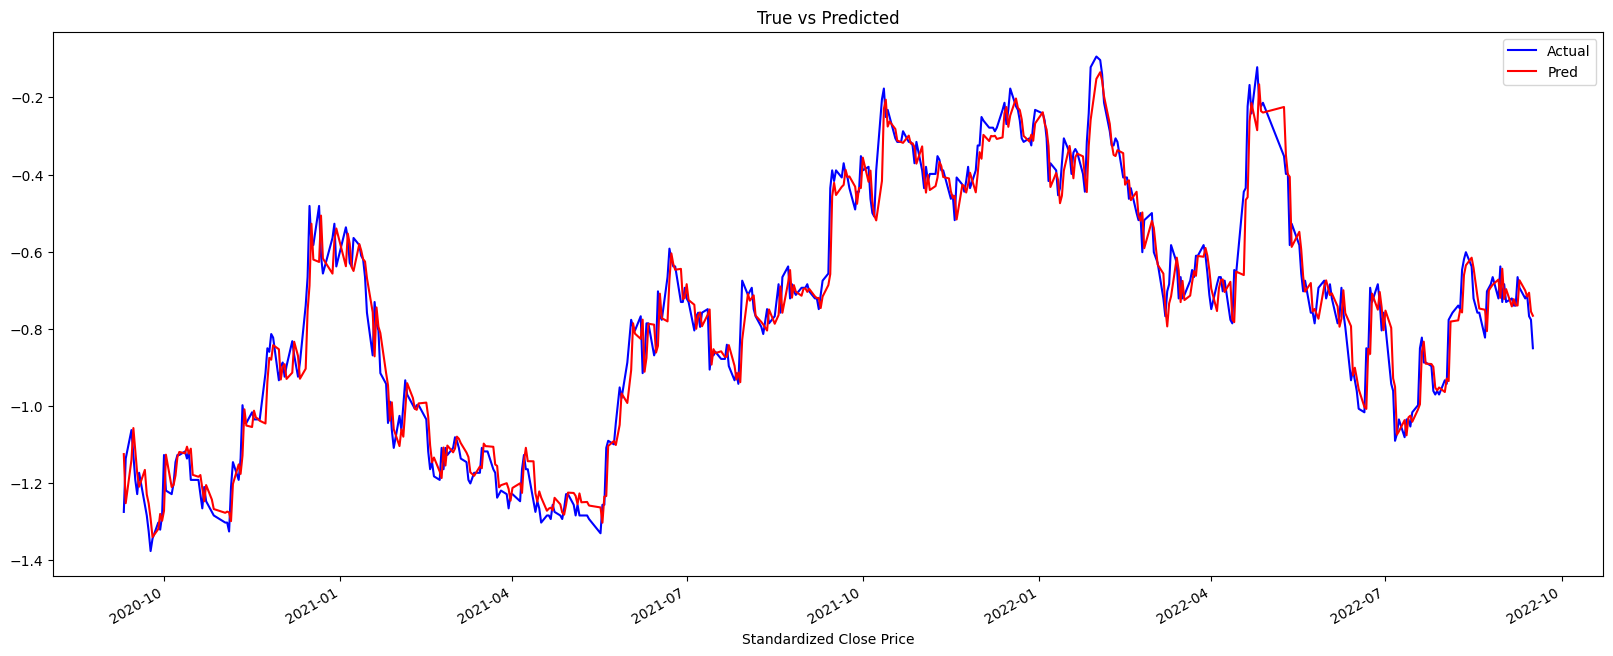

In [32]:
plot_pred_act(predictions_dfs['Model-24'])

## Save the best model

In [33]:
import keras

In [34]:
models['Model-24'][0].save('./models/excl.h5')

In [35]:
loadedModel = keras.models.load_model('./models/excl.h5')

In [36]:
loadedModel.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 1, 100)            45200     
                                                                 
 dropout_46 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_47 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_47 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 125,701
Trainable params: 125,701
Non-trainable params: 0
_________________________________________________________________


In [37]:
yhat = loadedModel.predict(X_test)

16/16 [==============================] - 0s 1ms/step
